In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets
from tensorflow.applications import ResNet50


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
class Dataset(object):
  def __init__(self, batch_size, shuffle=False):
      self.batch_size = batch_size
      self.shuffle = shuffle

      train, _ = datasets.mnist.load_data()
      X, y = train
      X = X.astype(np.float32)/255.
      X = X.reshape((X.shape[0], -1))
      self.X = X
      self.y = y

  def __iter__(self):
    N, B = len(self.X), self.batch_size
    idxs = np.arange(N)
    if self.shuffle:
      np.random.shuffle(idxs)
    return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


dataset = Dataset(batch_size=25, shuffle=True)

dataset.X.shape, dataset.y.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((60000, 784), (60000,))

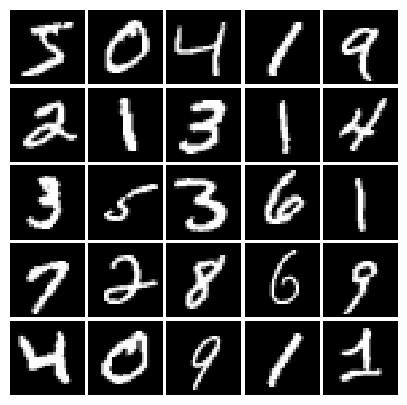

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

show_images(dataset.X[:25])

In [4]:
def Discriminator_model():
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[784]))
    model.add(Reshape([28, 28, 1]))
    model.add(Conv2D(32,(5, 5),strides = 1,padding = 'VALID'))
    model.add(LeakyReLU(0.01))
    model.add(MaxPooling2D((2, 2), strides = 2))
    model.add(Conv2D(64,(5, 5), strides = 1, padding = 'VALID'))
    model.add(LeakyReLU(0.01))
    model.add(MaxPooling2D((2,2), strides = 2))
    model.add(Flatten())
    model.add(LeakyReLU(0.01))
    model.add(Dense(1))
    
    return model

def Generator_model(Noise_dim):
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[Noise_dim]))
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(7*7*128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Reshape([7, 7, 128]))
    model.add(Conv2DTranspose(64,(4,4),strides = 2,activation = 'relu',padding = 'SAME'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1,(4,4),strides = 2,activation = 'tanh',padding = 'SAME'))
    model.add(Flatten())
    
    return model

Discriminator = Discriminator_model()
Generator = Generator_model(100)

Discriminator.summary()
Generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,121 (207.50 KB)

 Trainable params: 53,121 (207.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 1024)                │         103,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6272)                │       6,428,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6272)                │          25,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,693,825 (25.53 MB)

 Trainable params: 6,679,105 (25.48 MB)

 Non-trainable params: 14,720 (57.50 KB)

In [5]:
def discriminator_loss(real_images_output, fake_images_output):
    real_loss = 0.5*tf.reduce_mean(tf.square(real_images_output - 1)) 
    fake_loss = 0.5*tf.reduce_mean(tf.square(fake_images_output - 0))
    return (real_loss + fake_loss)

def generator_loss(fake_images_output):
    loss = 0.5*tf.reduce_mean((tf.square(fake_images_output-1)))
    return loss

def Optimizers():
    Generator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1= 0.5)
    Discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5)

    return Generator_optimizer, Discriminator_optimizer

Generator_optimizer, Discriminator_optimizer = Optimizers()

Final images


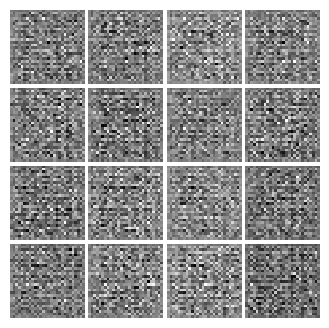

In [6]:
def generate_noise(batch_size, noise_dimension):
    noise = tf.random.uniform(shape=(batch_size, noise_dimension), minval=-1, maxval=1)
    return noise

z = generate_noise(25, 100)
G_sample = Generator(z)
print('Final images')
show_images(G_sample[:16])
plt.show()


In [ ]:
cnt = 0
num_epochs = 10

for epochs in range(num_epochs):
    for (x, y) in dataset:

          for _ in range(1):
              with tf.GradientTape() as disc_tape:

                batch_size = x.shape[0]
                ##Discriminator:
                real_output = Discriminator(2*x - 1, training = True)
                noise = generate_noise(batch_size, 100)
                fake_output = Discriminator(Generator(noise, training = True), training = True)
                #print(fake_output, real_output)
                disc_loss = discriminator_loss(real_output, fake_output)

                gradients_of_discriminator = disc_tape.gradient(disc_loss, Discriminator.trainable_variables)
                Discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, Discriminator.trainable_variables))

          for _ in range(1):
              with tf.GradientTape() as gen_tape:
                noise = generate_noise(x.shape[0], 100)
                fake_output = Discriminator(Generator(noise, training = True), training = True)
                gen_loss = generator_loss(fake_output)
    
                gradients_of_generator = gen_tape.gradient(gen_loss, Generator.trainable_variables)
                Generator_optimizer.apply_gradients(zip(gradients_of_generator, Generator.trainable_variables))

Final images


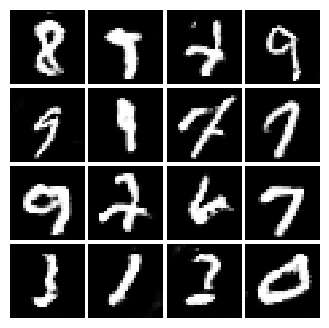

In [17]:
z = generate_noise(25, 100)
G_sample = Generator(z)
print('Final images')
show_images(G_sample[:16])
plt.show()

In [13]:
Generator.save_weights('/kaggle/working/generator.weights.h5')
Discriminator.save_weights('/kaggle/working/discriminator.weights.h5')